# Demonstration of the QLSAs workflow, following the qiskit patterns framework

In [1]:
# Set system path

from pathlib import Path
import sys


def find_repo_root(start: Path | None = None) -> Path:
    p = (start or Path.cwd()).resolve()
    for d in (p, *p.parents):
        if (d / ".git").exists() or (d / "pyproject.toml").exists() or (d / "src").exists():
            return d
    return p  # fallback


repo_root = find_repo_root()
print(repo_root)

# This repo uses a "src layout" (the Python package lives in <repo>/src/qlsas),
# but the repo is not installed as a package. Add <repo>/src to sys.path.
src_dir = repo_root / "src"
if src_dir.exists() and str(src_dir) not in sys.path:
    sys.path.insert(0, str(src_dir))

# Also add the repo root so you can import top-level modules like
# `linear_systems_problems.random_matrix_generator`.
if str(repo_root) not in sys.path:
    sys.path.insert(0, str(repo_root))

/Users/adrianharkness/QCOL_COPT/HHL/QLSAs


In [2]:
# Import QLSAs modules

from qlsas.qlsa.hhl import HHL
from qlsas.state_prep.prepare import StatePrep
from qlsas.transpiler.qiskit_transpiler import QiskitTranspiler
from linear_systems_problems.random_matrix_generator import generate_problem

import numpy as np
import math
from qiskit_ibm_runtime import QiskitRuntimeService
from qiskit.compiler.transpiler import generate_preset_pass_manager
from qiskit.primitives import StatevectorSampler
from qiskit_ibm_runtime import SamplerV2 as Sampler
from qiskit.visualization import plot_distribution


## Step 0: **Define** the (classical) problem

In [3]:
prob = generate_problem(n=4, cond_number=5.0, sparsity=0.5, seed=0)
A, b = prob["A"], prob["b"]

A  = A / np.linalg.norm(b)
b = b / np.linalg.norm(b)

print(f"A: {A}")
print()
print(f"b: {b}")


A: [[ 1.54139163e+00  3.12873261e-16  1.99492584e-16 -1.22724057e-01]
 [ 3.12873261e-16  1.86896928e+00  3.35918080e-01  9.74511280e-02]
 [ 1.99492584e-16  3.35918080e-01  1.48504671e+00 -7.46303192e-17]
 [-1.22724057e-01  9.74511280e-02 -7.46303192e-17  4.34057902e-01]]

b: [-0.25782857 -0.96179034 -0.09050706  0.01709523]


## Step 1: **Map** problem to quantum circuits and operators

In [4]:
hhl = HHL(
    A = A, 
    b = b, 
    state_prep_circuit = StatePrep('default'), 
    readout = 'swap_test', 
    swap_test_vector = np.ones(len(b)) / np.linalg.norm(np.ones(len(b))),
    num_qpe_qubits = math.log2(len(b)), 
    t0 = 2 * np.pi)

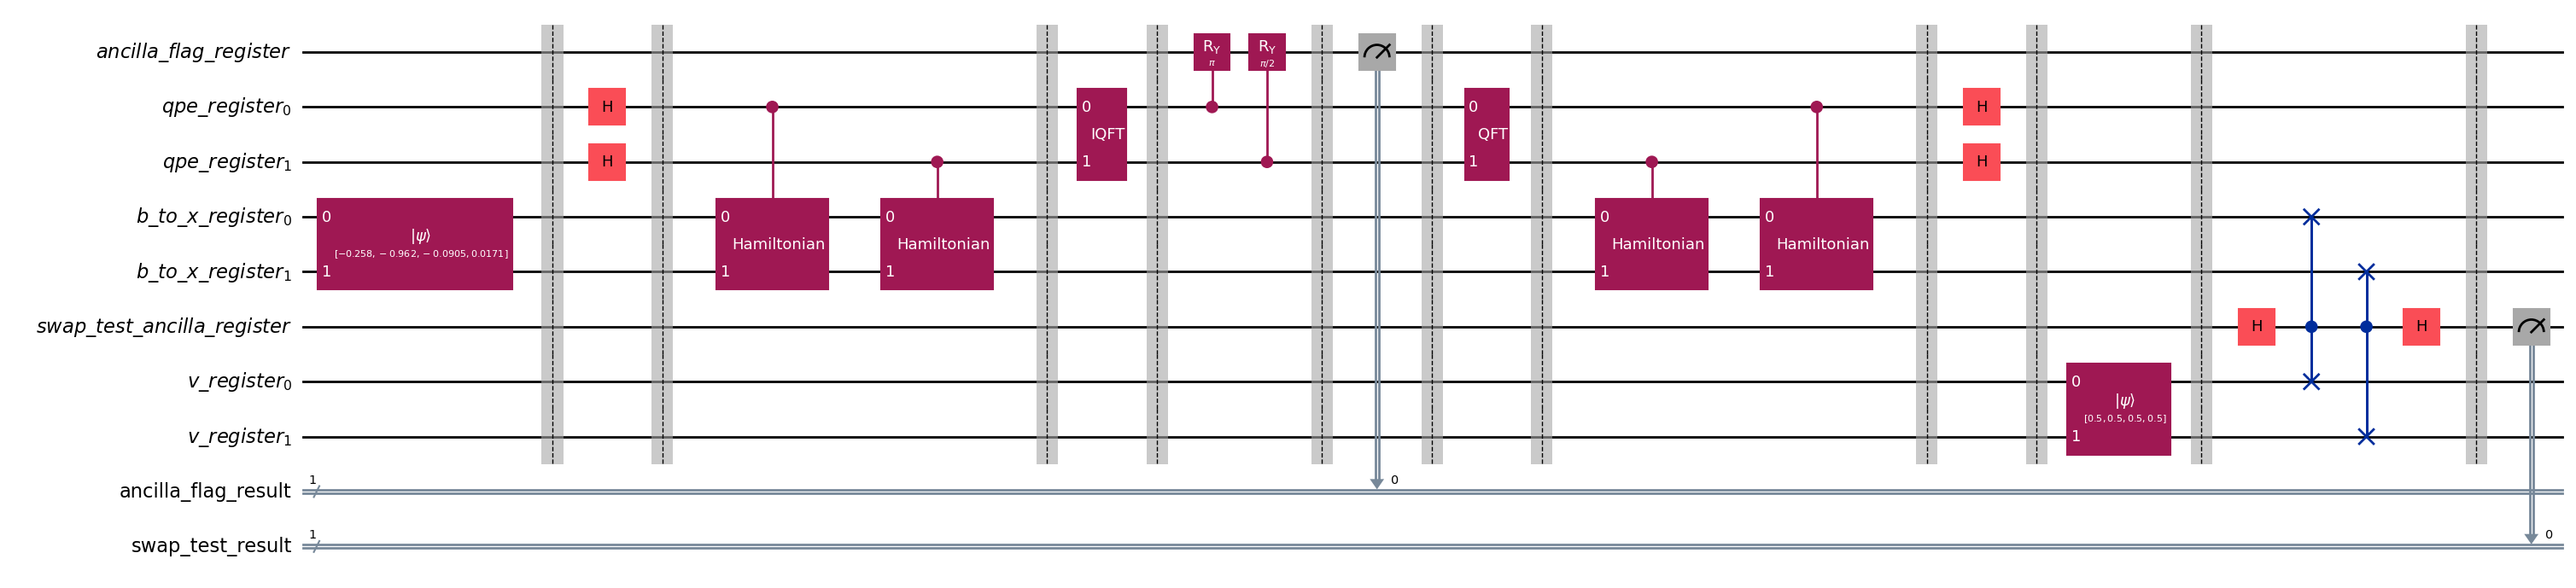

In [13]:
hhl_circuit = hhl.build_circuit()
hhl_circuit.draw(output='mpl', fold=-1)

## Step 2: **Optimize** for target hardware

In [6]:
service = QiskitRuntimeService(name="QLSAs")
service.backends()

[<IBMBackend('ibm_pittsburgh')>,
 <IBMBackend('ibm_boston')>,
 <IBMBackend('ibm_fez')>,
 <IBMBackend('ibm_torino')>,
 <IBMBackend('ibm_miami')>,
 <IBMBackend('ibm_marrakesh')>,
 <IBMBackend('ibm_kingston')>]

In [7]:
service = QiskitRuntimeService(name="QLSAs")
#backend = service.backend("ibm_boston")
backend = service.least_busy(
    operational=True,
    min_num_qubits=hhl_circuit.num_qubits
)
print("Backend: ", backend)

pm = generate_preset_pass_manager(optimization_level=3, backend=backend)

transpiled_hhl_circuit = pm.run(hhl_circuit)

print(
    f"2q-depth: {transpiled_hhl_circuit.depth(lambda x: x.operation.num_qubits==2)}"
)
print(
    f"2q-size: {transpiled_hhl_circuit.size(lambda x: x.operation.num_qubits==2)}"
)
print(f"Operator counts: {transpiled_hhl_circuit.count_ops()}")

Backend:  <IBMBackend('ibm_boston')>
2q-depth: 219
2q-size: 225
Operator counts: OrderedDict([('sx', 519), ('rz', 442), ('cz', 225), ('x', 39), ('barrier', 11), ('reset', 4), ('measure', 2)])


## Step 3: **Execute** on target hardware

In [8]:
#simulated_sampler = StatevectorSampler()
real_sampler = Sampler(mode=backend)
job = real_sampler.run([transpiled_hhl_circuit], shots = 250)
print(f">>> Job ID: {job.job_id()}")
print(f">>> Job Status: {job.status()}")

>>> Job ID: d5ahl1rht8fs73a5n5ig
>>> Job Status: QUEUED


In [9]:
result = job.result()[0]
print(f">>> Job Status: {job.status()}")

>>> Job Status: DONE


In [10]:
counts = result.join_data().get_counts()
counts

{'10': 56, '00': 114, '01': 53, '11': 27}

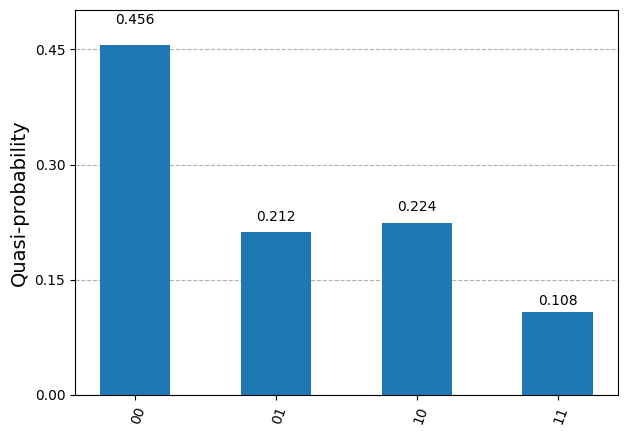

In [11]:
plot_distribution(counts)

In [12]:
available_algorithms = {
    "hhl": HHLAlgorithm,
    "vqls": VQLSAlgorithm,
    "qhd": QHDAlgorithm,
}

for name, cls in available_algorithms.items():
    print(f"{name.upper():<6} → {cls.__name__}")

hhl = HHLAlgorithm(
    n_qpe_qubits=3,
    t0=2 * np.pi,
)

algorithm = Algorithm(hhl)

NameError: name 'HHLAlgorithm' is not defined

In [ ]:
backend_config = LocalAerBackendConfig(
    target="aer_simulator_statevector",
    shots=4096,
    optimization_level=3,
    noise_model=None,
)
backend = QiskitBackendRunner.from_config(backend_config)

In [ ]:
solver = LinearSystemSolver(
    algorithm=algorithm,
    backend=backend
).refine(
    max_iterations=3,
    tolerance=1e-6,
)

solver

In [ ]:
overlap = LinearSystemSolver(
    algorithm=algorithm,
    backend=backend
).swap_test(
    phi=vec
)


## Step 3 : Execute and Inspect Results

Run the solver and collect the diagnostics returned by the backend and optional refiner.

In [ ]:
result = solver.solve(
    A=A,
    b=b,
    job_label="demo-hhl-noiseless",
    verbose=True,
)

solution = result.solution
metadata = result.metadata

print("Solver complete!")
print(f"Solution vector (normalized): {solution}")
print(f"Residual ‖Ax - b‖₂ = {np.linalg.norm(A @ solution - b):.3e}")
print(f"Error ‖x - x_classical‖₂ = {np.linalg.norm(solution - classical_solution):.3e}")

In [ ]:
residual_history = metadata.get("residuals", [])
error_history = metadata.get("errors", [])
circuit_stats = metadata.get("circuit", {})
counts = metadata.get("counts")

print(f"Stored residuals: {len(residual_history)}")
print(f"Stored errors: {len(error_history)}")

if circuit_stats:
    print("\nCircuit statistics:")
    for key, value in circuit_stats.items():
        print(f"  {key}: {value}")

if counts is not None:
    preview = list(counts.items())[:5]
    print("\nPreview of measurement counts:")
    for bitstring, freq in preview:
        print(f"  {bitstring}: {freq}")

In [ ]:
if residual_history:
    plt.figure(figsize=(6, 4))
    plt.plot(range(len(residual_history)), residual_history, marker="o")
    plt.yscale("log")
    plt.xlabel("Iteration")
    plt.ylabel("Residual norm")
    plt.title("Residual history")
    plt.grid(True, which="both", linestyle=":")
    plt.show()
else:
    print("Residual history not available.")

if error_history:
    plt.figure(figsize=(6, 4))
    plt.plot(range(len(error_history)), error_history, marker="o", color="tab:orange")
    plt.yscale("log")
    plt.xlabel("Iteration")
    plt.ylabel("Error norm")
    plt.title("Error history")
    plt.grid(True, which="both", linestyle=":")
    plt.show()
else:
    print("Error history not available.")